https://ai.stanford.edu/~amaas/data/sentiment/

https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

In [1]:
import emoji
import glob
import numpy as np
import os
import pandas as pd
import re
import requests
import tarfile

from collections import Counter
from tqdm import tqdm

import matplotlib.pyplot as plt

# Load data

In [ ]:
def get_data():
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    filename = "aclImdb_v1.tar.gz"
    
    print("Downloading file...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    
    with open(filename, 'wb') as file, tqdm(
            desc=filename,
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
        for data in response.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)
    
    print("Extracting file...")
    if os.path.exists("aclImdb"):
        shutil.rmtree("aclImdb")
    with tarfile.open(filename) as tar:
        tar.extractall(filter='data')

    print("Renaming folder...")
    if os.path.exists("data/raw"): 
        shutil.rmtree("data/raw")
    if not os.path.exists("data"):
        os.makedirs("data")
    os.rename("aclImdb", "data/raw")
    
    print("Cleaning up...")
    os.remove(filename)
    
    print("Done! The dataset is now available in the 'data/raw' folder.")

if __name__ == "__main__":
    get_data()

In [ ]:
def process_data(base_dir):
    train_data = []
    test_data = []
    unsup_data = []
    
    # Process both train and test splits
    for split in ['train', 'test']:
        split_path = os.path.join(base_dir, split)
            
        # Process positive and negative reviews
        for sentiment in ['pos', 'neg']:
            sentiment_path = os.path.join(split_path, sentiment)
            sentiment_label = 'positive' if sentiment == 'pos' else 'negative'
            
            # Skip if directory doesn't exist
            if not os.path.exists(sentiment_path):
                print(f"Warning: {sentiment_path} does not exist")
                continue
                
            # Find all text files
            files = glob.glob(os.path.join(sentiment_path, '*.txt'))
            
            for file_path in files:
                # Extract id and rating from filename
                filename = os.path.basename(file_path)
                match = re.match(r'(\d+)_(\d+)\.txt', filename)
                
                if match:
                    review_id, rating = match.groups()
                    
                    # Read the review text
                    with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
                        text = f.read().strip()
                    
                    # Add to appropriate list based on split
                    entry = {
                        'id': int(review_id),
                        'text': text,
                        'sentiment': sentiment_label,
                        'rating': int(rating)
                    }
                    
                    if split == 'train':
                        train_data.append(entry)
                    else:
                        test_data.append(entry)
        
        # Process unsupervised data in train split)
        if split == 'train':
            unsup_path = os.path.join(split_path, 'unsup')
            files = glob.glob(os.path.join(unsup_path, '*.txt'))
                
            for file_path in files:
                # Extract id from filename
                filename = os.path.basename(file_path)
                match = re.match(r'(\d+)_0\.txt', filename)
                    
                if match:
                    review_id = match.groups()[0]
                        
                    # Read the review text
                    with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
                        text = f.read().strip()
                        
                    # Add to unsupervised data list
                    unsup_data.append({
                        'id': int(review_id),
                        'text': text
                    })
    
    # Convert lists to DataFrames
    train = pd.DataFrame(train_data)
    test = pd.DataFrame(test_data)
    unsup = pd.DataFrame(unsup_data)
    
    return train, test, unsup

train, test, unsup = process_data("data/raw/")

os.makedirs("data/processed/", exist_ok=True)
train.to_csv("data/processed/train.csv", index=False)
test.to_csv("data/processed/test.csv", index=False)
unsup.to_csv("data/processed/unsup.csv", index=False)

In [ ]:
# Check that data is correctly loaded
print(f"Train data shape: {train.shape}")
print(f"Test data shape: {test.shape}")
print(f"Unsupervised data shape: {unsup.shape}")

print("\nTrain data:")
print(train.head(2))
print("\n")
print("\nTest data sample:")
print(test.head(2))
print("\n")
print("\nUnsupervised data sample:")
print(unsup.head(2))

# Clean data

In [2]:
train = pd.read_csv("data/processed/train.csv")
test = pd.read_csv("data/processed/test.csv")

In [10]:
np.sort(train['id'].unique())

array([    0,     1,     2, ..., 12497, 12498, 12499])

In [11]:
np.sort(test['id'].unique())

array([    0,     1,     2, ..., 12497, 12498, 12499])

In [7]:
common_ids = set(train['id'].unique()) & set(test['id'].unique())
count_common_ids = len(common_ids)

print(f"Number of unique id values that appear in both train and test: {count_common_ids}")

Number of unique id values that appear in both train and test: 12500


## HTML markups

In [3]:
def contains_html_tags(text):
    pattern = re.compile(r'<[^>]+>')
    return bool(pattern.search(str(text)))

train['has_html'] = train['text'].apply(contains_html_tags)
test['has_html'] = test['text'].apply(contains_html_tags)

train_html_count = train['has_html'].sum()
train_total_count = len(train)
train_percentage = (train_html_count / train_total_count) * 100

test_html_count = test['has_html'].sum()
test_total_count = len(test)
test_percentage = (test_html_count / test_total_count) * 100

print(f"Reviews containing HTML markup in train: {train_html_count} out of {train_total_count} ({train_percentage:.2f}%)")
print(f"Reviews containing HTML markup in test: {test_html_count} out of {train_total_count} ({test_percentage:.2f}%)")

Reviews containing HTML markup in train: 14667 out of 25000 (58.67%)
Reviews containing HTML markup in test: 14535 out of 25000 (58.14%)


In [4]:
def extract_html_tags(text):
    pattern = re.compile(r'<([a-zA-Z][a-zA-Z0-9]*)')
    matches = pattern.findall(str(text))
    return matches

if train_html_count + test_html_count > 0:
    all_tags = []
    for text in train[train['has_html']]['text']:
        tags = extract_html_tags(text)
        all_tags.extend(tags)

    for text in test[test['has_html']]['text']:
        tags = extract_html_tags(text)
        all_tags.extend(tags)
    
    tag_counts = Counter(all_tags)
    
    print("\nMost common HTML tags:")
    for tag, count in tag_counts.most_common(10):
        print(f"{tag} ({count})")


Most common HTML tags:
br (201948)
i (8)
grin (2)
SPOILER (1)
sigh (1)
em (1)
sp (1)
http (1)
hr (1)
p (1)


In [5]:
def remove_html_markups(text):
    # TReplace <SPOILER> tags with SPOILER
    text = re.sub(r'<SPOILER>', 'SPOILER', str(text))
    text = re.sub(r'</SPOILER>', 'SPOILER', str(text))
    
    # Remove all other HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    
    return text

train['text'] = train['text'].apply(remove_html_markups)
test['text'] = test['text'].apply(remove_html_markups)

train = train.drop(columns=['has_html'])
test = test.drop(columns=['has_html'])

## Emojis

In [6]:
# Count samples with emojis
train['has_emoji'] = train['text'].apply(lambda x: emoji.emoji_count(x) > 0)
train_emoji_count = train['has_emoji'].sum()
train_total = len(train)
train_percentage = (train_emoji_count / train_total) * 100

test['has_emoji'] = test['text'].apply(lambda x: emoji.emoji_count(x) > 0)
test_emoji_count = test['has_emoji'].sum()
test_total = len(test)
test_percentage = (test_emoji_count / test_total) * 100

print(f"Train set: {train_emoji_count} out of {train_total} samples contain emojis ({train_percentage:.2f}%)")
print(f"Test set: {test_emoji_count} out of {test_total} samples contain emojis ({test_percentage:.2f}%)")

Train set: 4 out of 25000 samples contain emojis (0.02%)
Test set: 1 out of 25000 samples contain emojis (0.00%)


In [7]:
# Get most common emojis
def extract_emojis(text):
    return ''.join(c for c in text if c in emoji.EMOJI_DATA)

all_train_emojis = ''.join(train['text'].apply(extract_emojis))
train_emoji_counts = Counter(all_train_emojis)

all_test_emojis = ''.join(test['text'].apply(extract_emojis))
test_emoji_counts = Counter(all_test_emojis)

print("\nMost common emojis in train set:")
for em, count in train_emoji_counts.most_common(10):
    print(f"{em} ({count})")

print("\nMost common emojis in test set:")
for em, count in test_emoji_counts.most_common(10):
    print(f"{em} ({count})")


Most common emojis in train set:
® (4)

Most common emojis in test set:
© (1)


In [8]:
def remove_emojis(text):
    text = re.sub(r'[®©]', '', str(text))
    
    return text

train['text'] = train['text'].apply(remove_emojis)
test['text'] = test['text'].apply(remove_emojis)

train = train.drop(columns=['has_emoji'])
test = test.drop(columns=['has_emoji'])

## Special characters

In [12]:
def has_special_chars(text):
    # Define a pattern that matches special characters/accented letters
    # but excludes common punctuation and standard ASCII letters/numbers
    pattern = re.compile(r'[^\x00-\x7F]+')  # Matches any non-ASCII character
    
    # Alternative approach with more specific exclusions:
    # pattern = re.compile(r'[^\w\s!@#$%^&*()_+\-=\[\]{};:\'",.<>/?\\|]')
    
    return bool(pattern.search(str(text)))

# Apply to your dataframe
train['has_special_chars'] = train['text'].apply(has_special_chars)

# Count samples with special characters
special_chars_count = train['has_special_chars'].sum()
total_count = len(train)
percentage = (special_chars_count / total_count) * 100

print(f"Texts containing special characters: {special_chars_count} out of {total_count} ({percentage:.2f}%)")

# Print some examples
if special_chars_count > 0:
    print("\nExamples of text with special characters:")
    for idx, row in train[train['has_special_chars']].head(5).iterrows():
        # Extract the special characters
        special_chars = re.findall(r'[^\x00-\x7F]', str(row['text']))
        unique_special_chars = set(special_chars)
        
        print(f"ID: {row['id']}")
        print(f"Text preview: {row['text'][:100]}...")
        print(f"Special characters found: {', '.join(unique_special_chars)}")
        print("-" * 80)

Texts containing special characters: 2342 out of 25000 (9.37%)

Examples of text with special characters:
ID: 3574
Text preview: It's hard to say sometimes why exactly a film is so effective. From the moment I first came across "...
Special characters found: í
--------------------------------------------------------------------------------
ID: 5245
Text preview: I thought this movie was LOL funny. It's a fun, not to be taken seriously, movie about one man's twi...
Special characters found: é
--------------------------------------------------------------------------------
ID: 12091
Text preview: `Castle of Blood' (aka `Castle of Terror') is a well-crafted, surprisingly spooky entry from Italian...
Special characters found: è
--------------------------------------------------------------------------------
ID: 2389
Text preview: I work with children from 0  6 years old and they all love the Doodlebops. The Doodlebops are energ...
Special characters found: 
------------------------------

# Description

## Ratings

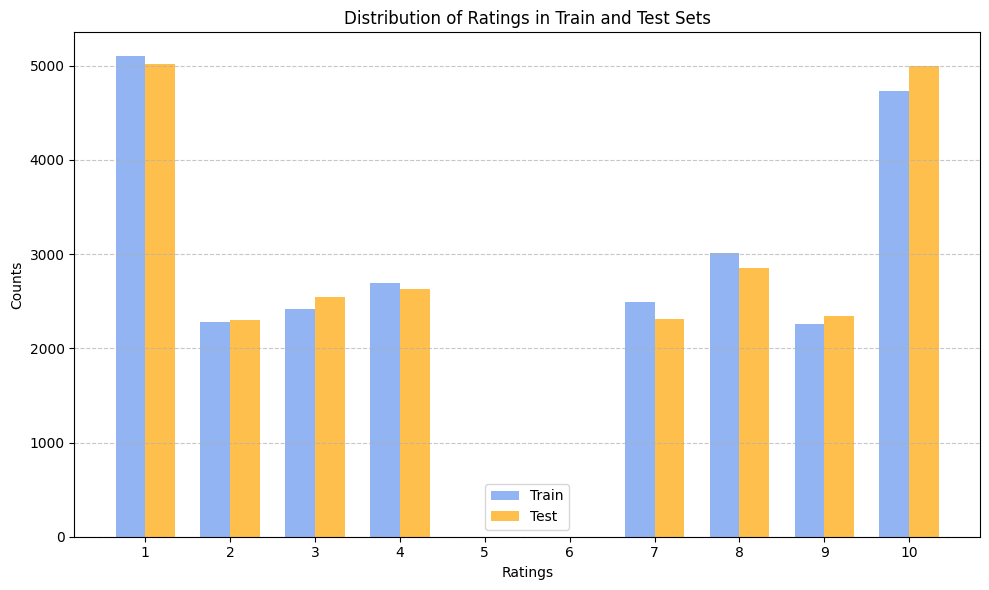

In [6]:
plt.figure(figsize=(10, 6))

ratings_range = range(1, 11)
x = np.array(ratings_range)
width = 0.35

train_counts = [train['rating'].value_counts().get(i, 0) for i in ratings_range]
test_counts = [test['rating'].value_counts().get(i, 0) for i in ratings_range]

plt.bar(x - width/2, train_counts, width, color='cornflowerblue', alpha=0.7, label='Train')
plt.bar(x + width/2, test_counts, width, color='orange', alpha=0.7, label='Test')

plt.xlabel('Ratings')
plt.ylabel('Counts')
plt.title('Distribution of Ratings in Train and Test Sets')
plt.xticks(ratings_range)
plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Length

In [7]:
def get_text_stats(df):
    # Character length
    df['char_length'] = df['text'].apply(len)
    char_min = df['char_length'].min()
    char_max = df['char_length'].max()
    char_avg = df['char_length'].mean()
    
    # Word length
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    word_min = df['word_count'].min()
    word_max = df['word_count'].max()
    word_avg = df['word_count'].mean()
    
    return {
        'char_min': char_min,
        'char_max': char_max,
        'char_avg': round(char_avg, 0),
        'word_min': word_min,
        'word_max': word_max,
        'word_avg': round(word_avg, 0)
    }

train_stats = get_text_stats(train)
test_stats = get_text_stats(test)

# Create a comparison dataframe
comparison = pd.DataFrame({
    'Train': [train_stats['char_min'],
              train_stats['char_max'],
              train_stats['char_avg'],
              train_stats['word_min'],
              train_stats['word_max'],
              train_stats['word_avg']],
    'Test': [test_stats['char_min'],
             test_stats['char_max'],
             test_stats['char_avg'],
             test_stats['word_min'],
             test_stats['word_max'],
             test_stats['word_avg']]}, 
    index=['Min Characters',
          'Max Characters',
          'Avg Characters',
          'Min Words',
          'Max Words',
          'Avg Words'])

comparison.style.set_caption('Text Length Statistics').format("{:.0f}")

,Train,Test
Min Characters,52,32
Max Characters,13704,12988
Avg Characters,1325,1294
Min Words,10,4
Max Words,2470,2278
Avg Words,234,229


In [8]:
train

,id,text,sentiment,rating,char_length,word_count
0,4715,For a movie that gets no respect there sure ar...,positive,9,284,52
1,12390,Bizarre horror movie filled with famous faces ...,positive,8,1033,166
2,8329,"A solid, if unremarkable film. Matthau, as Ein...",positive,7,318,55
3,9063,It's a strange feeling to sit alone in a theat...,positive,8,2596,442
4,3092,"You probably all already know this by now, but...",positive,10,783,144
...,...,...,...,...,...,...
24995,3307,"My comments may be a bit of a spoiler, for wha...",negative,3,978,168
24996,2240,"The ""saucy"" misadventures of four au pairs who...",negative,4,2473,431
24997,11556,"Oh, those Italians! Assuming that movies about...",negative,1,529,83
24998,4617,Eight academy nominations? It's beyond belief....,negative,3,2399,421


## Correlation

In [10]:
import scipy.stats as stats

correlation, p_value = stats.pearsonr(train['rating'], train['word_count'])

print(f"Pearson correlation coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

Pearson correlation coefficient: 0.0141
P-value: 0.0255


In [13]:
word_count_stats = train.groupby('rating')['word_count'].agg(['mean', 'median', 'count'])
print("\nWord count statistics by rating:")
print(word_count_stats)


Word count statistics by rating:
              mean  median  count
rating                           
1       211.595686   161.0   5100
2       226.199212   177.0   2284
3       250.685537   189.0   2420
4       253.491098   194.0   2696
7       260.793670   203.0   2496
8       252.252908   190.0   3009
9       245.346443   177.0   2263
10      209.983728   154.0   4732


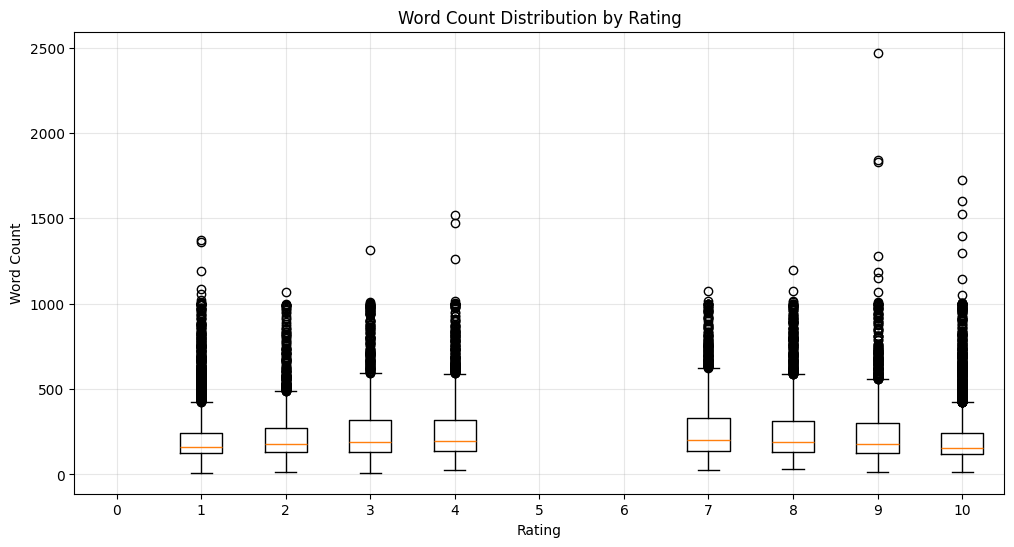

In [20]:
plt.figure(figsize=(12, 6))
plt.boxplot([train[train['rating'] == i]['word_count'] for i in range(0, 11)], 
           tick_labels=range(0, 11))
plt.xlabel('Rating')
plt.ylabel('Word Count')
plt.title('Word Count Distribution by Rating')
plt.grid(True, alpha=0.3)
plt.show()

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

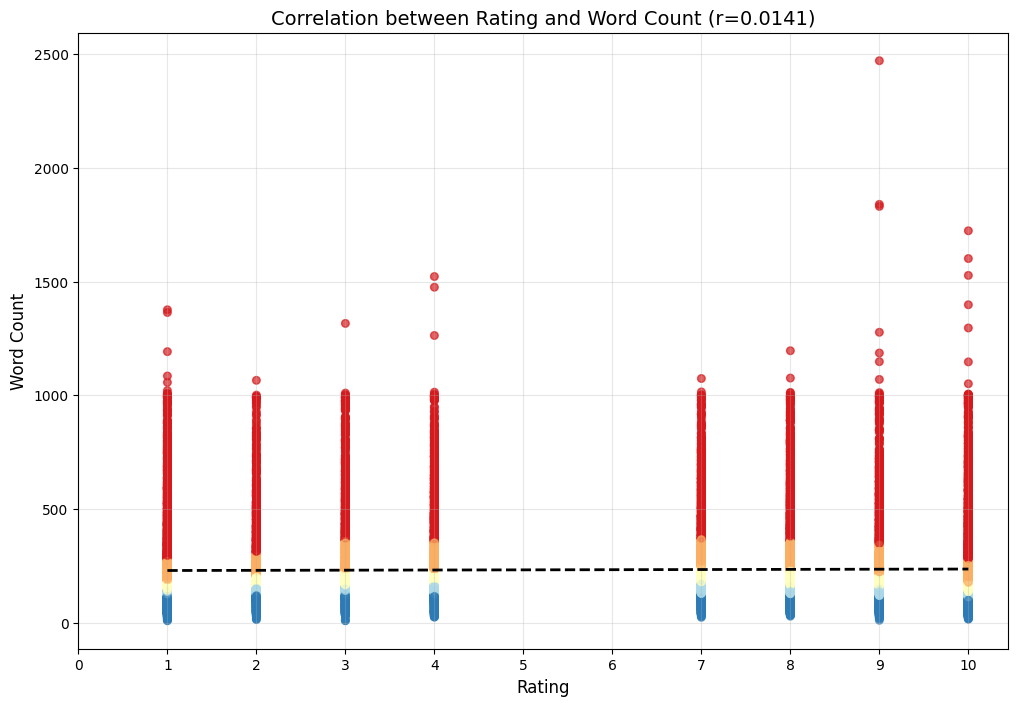

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap

# Make sure you have the word_count column
if 'word_count' not in train.columns:
    train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))

# Create a figure
plt.figure(figsize=(12, 8))

# Define a colormap
colors = ['#2c7bb6', '#abd9e9', '#ffffbf', '#fdae61', '#d7191c']  # Blue to Red
cmap = ListedColormap(colors)

# For each rating value
for rating in sorted(train['rating'].unique()):
    # Get the subset of data for this rating
    subset = train[train['rating'] == rating]
    
    if len(subset) > 0:
        # Calculate quintiles for this rating's word counts
        quintiles = pd.qcut(subset['word_count'], q=5, labels=False, duplicates='drop')
        
        # If there are enough data points to create quintiles
        if len(np.unique(quintiles)) > 1:
            # Plot points with color based on quintile
            plt.scatter(
                [rating] * len(subset),   # x-values (all the same rating)
                subset['word_count'],     # y-values (word counts)
                c=quintiles,              # color based on quintile
                cmap=cmap,                # color map
                alpha=0.7,                # transparency
                s=30                      # size of points
            )
        else:
            # Not enough data points for quintiles, use single color
            plt.scatter(
                [rating] * len(subset),
                subset['word_count'],
                color=colors[2],  # Middle color
                alpha=0.7,
                s=30
            )

# Add a trend line
x = train['rating']
y = train['word_count']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(np.unique(x), p(np.unique(x)), "k--", lw=2)

# Calculate correlation coefficient
correlation = np.corrcoef(train['rating'], train['word_count'])[0, 1]

# Add labels and title
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.title(f'Correlation between Rating and Word Count (r={correlation:.4f})', fontsize=14)
plt.xticks(np.arange(0, 11, 1))  # Set x-axis ticks to integers 0-10
plt.grid(True, alpha=0.3)

# Add a color bar legend
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
sm = ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=4))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Quintile within Rating Group', fontsize=10)
cbar.set_ticks([0.4, 1.2, 2, 2.8, 3.6])
cbar.set_ticklabels(['1st', '2nd', '3rd', '4th', '5th'])

plt.tight_layout()
plt.show()